In [181]:
import warnings 
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Data handling
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

# Vizualisation (Matplotlib, Plotly, Seaborn, etc. )
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.colors as colors
from plotly.subplots import make_subplots

# EDA (pandas-profiling, etc. )
import scipy.stats as stats
from statsmodels.tsa.stattools import kpss
from scipy.stats import t, ttest_ind, chi2_contingency


# Feature Processing (Scikit-learn processing, etc. )
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Machine Learning (Scikit-learn Estimators, Catboost, LightGBM, etc. )


# Hyperparameters Fine-tuning (Scikit-learn hp search, cross-validation, etc. )


# Other packages
import os, pickle

In [182]:
holidays=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv", parse_dates =['date'])
oil=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv", parse_dates =['date'])
sample=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv")
stores=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")
test=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv", parse_dates =['date'])
train=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv", parse_dates =['date'])
transactions=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/transactions.csv", parse_dates =['date'])


3. Data Preparation
Data Issues
Deal with missing vales after merging, creating new features and adding missing dates
Rename a few columns to be more readable
Ensure dtypes are correct for each column

In [183]:
# shape overview to doubleckeck

train.shape, test.shape

((3000888, 6), (28512, 5))

In [184]:

# check for duplicates

train.duplicated().any(), 
stores.duplicated().any(), 
oil.duplicated().any(),  
test.duplicated().any(),  
holidays.duplicated().any(),
transactions.duplicated().any()

False

In [185]:

null_rows = train[train['id'].isnull()]
null_rows

,id,date,store_nbr,family,sales,onpromotion


In [186]:

train.tail()

,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


In [187]:
min_date = train['date'].min()
max_date = train['date'].max()
days_range = pd.date_range(start=min_date, end=max_date)
num_days = len(days_range)

In [188]:
expected_dates = pd.date_range(start=min_date, end=max_date)
missing_dates = expected_dates.difference(train['date'].unique())
missing_df = list(missing_dates)
new_dates = pd.DataFrame(missing_df, columns = ['date'])
train = pd.concat([train, new_dates], ignore_index=False)

In [189]:
train.isna().sum()

id             4
date           0
store_nbr      4
family         4
sales          4
onpromotion    4
dtype: int64

In [190]:
# replace null values in id column

train.loc[train['date'] == '2013-12-25', 'id'] = 3000888
train.loc[train['date'] == '2014-12-25', 'id'] = 3000889
train.loc[train['date'] == '2015-12-25', 'id'] = 3000890
train.loc[train['date'] == '2016-12-25', 'id'] = 3000891

In [191]:

cols = ["store_nbr", "sales", "onpromotion"]

# Fill null values in numerical columns with 0
train[cols] = train[cols].fillna(0)

# Fill null values in family column
train['family'] = train['family'].fillna('none')

In [192]:

train.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [193]:
# we had some missing values in the oil dataset

oil['dcoilwtico'].isna().sum()

43

In [194]:
#Filling missing values in oil data with the the value before that missing data

oil= oil.bfill()

In [195]:
# check again to confirm

oil['dcoilwtico'].isna().sum()

0

# Preparing Train Data

In [196]:
# Merge train and stores datasets
df_train1 = pd.merge(train, stores, on="store_nbr")

# Merge df_train1 with oil_df and holidays_df
merged_train = pd.merge(df_train1, oil, on="date", how="left")
merged_train = pd.merge(merged_train, holidays, on="date", how="left")

merged_train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,dcoilwtico,type_y,locale,locale_name,description,transferred
0,0.0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False
1,1.0,2013-01-01,1.0,BABY CARE,0.0,0.0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False
2,2.0,2013-01-01,1.0,BEAUTY,0.0,0.0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False
3,3.0,2013-01-01,1.0,BEVERAGES,0.0,0.0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False
4,4.0,2013-01-01,1.0,BOOKS,0.0,0.0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False


In [197]:

# drop categorical columns not relevant to analysis

merged_train= merged_train.drop(columns=["state", "type_x", "city", "locale", "locale_name", "description", "transferred"])
merged_train.head()

,id,date,store_nbr,family,sales,onpromotion,cluster,dcoilwtico,type_y
0,0.0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0,13,93.14,Holiday
1,1.0,2013-01-01,1.0,BABY CARE,0.0,0.0,13,93.14,Holiday
2,2.0,2013-01-01,1.0,BEAUTY,0.0,0.0,13,93.14,Holiday
3,3.0,2013-01-01,1.0,BEVERAGES,0.0,0.0,13,93.14,Holiday
4,4.0,2013-01-01,1.0,BOOKS,0.0,0.0,13,93.14,Holiday


In [198]:
# remane columnswith relevant names

merged_train.rename(columns = {"cluster":"store_cluster", "dcoilwtico":"oil_price", "type_y":"events"}, inplace=True)

In [199]:
# check unique values in events column

merged_train["events"].unique()

array(['Holiday', nan, 'Work Day', 'Additional', 'Event', 'Transfer',
       'Bridge'], dtype=object)

In [200]:
# Rename values in events column

merged_train["events"].replace(to_replace={"Bridge", "Event", "Additional"}, value="Holiday", inplace=True) 
merged_train["events"].replace(to_replace={"Work Day", "Transfer"}, value="No holiday", inplace=True)

In [201]:
# check for null values

merged_train["events"].isna().sum()

2551824

In [202]:
# Fill missing values with 'no holiday'

merged_train["events"].fillna("No holiday", inplace=True)

# Replace 'holidays' with 1 and other events with 0

merged_train['events'] = merged_train['events'].replace('Holiday', 1).replace('No holiday', 0)

In [203]:
# check unique values

merged_train["events"].unique()

array([1, 0])

In [204]:
# reclassification of product family to reduce number of categorical variables to encode

merged_train["family"].replace(to_replace={"GROCERY I", "GROCERY II", "EGGS", "PRODUCE", "DAIRY", "BREAD/BAKERY", "DELI", "PREPARED FOODS"}, value="GROCERY", inplace=True)
merged_train["family"].replace(to_replace={"HOME AND KITCHEN I", "HOME AND KITCHEN II", "HOME APPLIANCES", "HARDWARE", "PLAYERS AND ELECTRONICS"}, value="HOME AND KITCHEN", inplace=True)
merged_train["family"].replace(to_replace={"MEATS", "POULTRY", "SEAFOOD"}, value="FROZEN FOODS", inplace=True)
merged_train["family"].replace(to_replace={"HOME CARE", "LAWN AND GARDEN", "CLEANING"}, value="HOME CARE AND GARDEN", inplace=True)
merged_train["family"].replace(to_replace={"BEAUTY", "BABY CARE", "LADIESWEAR", "LINGERIE", "PERSONAL CARE"}, value="BEAUTY AND FASHION", inplace=True)
merged_train["family"].replace(to_replace={"LIQUOR,WINE,BEER", "BEVERAGES"}, value="BEVERAGES AND LIQUOR", inplace=True)
merged_train["family"].replace(to_replace={"MAGAZINES", "BOOKS", "CELEBRATION"}, value="SCHOOL AND OFFICE SUPPLIES", inplace=True)

In [205]:
# check unique values

merged_train["family"].unique()

array(['AUTOMOTIVE', 'BEAUTY AND FASHION', 'BEVERAGES AND LIQUOR',
       'SCHOOL AND OFFICE SUPPLIES', 'GROCERY', 'HOME CARE AND GARDEN',
       'FROZEN FOODS', 'HOME AND KITCHEN', 'PET SUPPLIES'], dtype=object)

In [206]:
merged_train.isna().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
store_cluster         0
oil_price        878526
events                0
dtype: int64

In [207]:
# filling missing values

merged_train["oil_price"].fillna(method="bfill", inplace=True)

In [208]:
# check cols and rows

merged_train.shape

(3054348, 9)

# Feature Engineering

In [209]:
# Create new features

merged_train["Year"] = merged_train['date'].dt.year
merged_train["Month"] = merged_train['date'].dt.month
merged_train['Day'] = merged_train['date'].dt.day
merged_train['quarter'] = merged_train['date'].dt.quarter 
merged_train['week_of_year'] = merged_train['date'].dt.isocalendar().week
merged_train['day_of_week'] = merged_train['date'].dt.dayofweek
merged_train["is_weekend"] = np.where(merged_train['day_of_week'] > 4, 1, 0)

In [210]:
merged_train['week_of_year'] = merged_train['week_of_year'].astype(int)

In [211]:
merged_train.tail()

,id,date,store_nbr,family,sales,onpromotion,store_cluster,oil_price,events,Year,Month,Day,quarter,week_of_year,day_of_week,is_weekend
3054343,3000883.0,2017-08-15,9.0,FROZEN FOODS,438.133,0.0,6,47.57,1,2017,8,15,3,33,1,0
3054344,3000884.0,2017-08-15,9.0,GROCERY,154.553,1.0,6,47.57,1,2017,8,15,3,33,1,0
3054345,3000885.0,2017-08-15,9.0,GROCERY,2419.729,148.0,6,47.57,1,2017,8,15,3,33,1,0
3054346,3000886.0,2017-08-15,9.0,SCHOOL AND OFFICE SUPPLIES,121.000,8.0,6,47.57,1,2017,8,15,3,33,1,0
3054347,3000887.0,2017-08-15,9.0,FROZEN FOODS,16.000,0.0,6,47.57,1,2017,8,15,3,33,1,0


In [212]:
merged_train.to_csv('merged_train_data.csv', index=False)

# Resampling

In [213]:
# resample data to monthly frequency and compute the mean of sales for each month
cols = ['date', 'sales']

merged_monthly_mean = merged_train[cols].set_index('date').resample('M').mean()
print(merged_monthly_mean.shape)
merged_monthly_mean.tail(3)

(56, 1)


,sales
date,
2017-06-30,488.707278
2017-07-31,489.909880
2017-08-31,465.144891


Stationarity Test
A time series has to have some statistical properties to be able to stationary:

Constant mean: There is no trend over time.
Constant variance, covariance: The scale of the data doesn’t change and the relationship between observations is consistent.
No seasonality: Statistical properties of seasonal data changes regularly. Therefore, there is a pattern of change in the mean.

In [214]:
fig = px.line(merged_monthly_mean, x=merged_monthly_mean.index, y='sales', title='Mean of Monthly Sales')
fig.update_xaxes(rangeslider_visible=True)

fig.show()


Ho (Null Hypothesis): The time series data is non-stationary
H1 (alternate Hypothesis): The time series data is stationary

# KPSS Test

In [215]:
stats, p, lags, critical_values=kpss(merged_train['sales'], 'ct')

print(f'Test_statistics: {stats}')
print(f'p-value: {p}')
print(f'Critical values: {critical_values}')

if p < 0.05 :
    print('Series is not stationary')
else :
    print('Series is stationary')

Test_statistics: 1.1447155909908964
p-value: 0.01
Critical values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Series is not stationary


# Decomposing

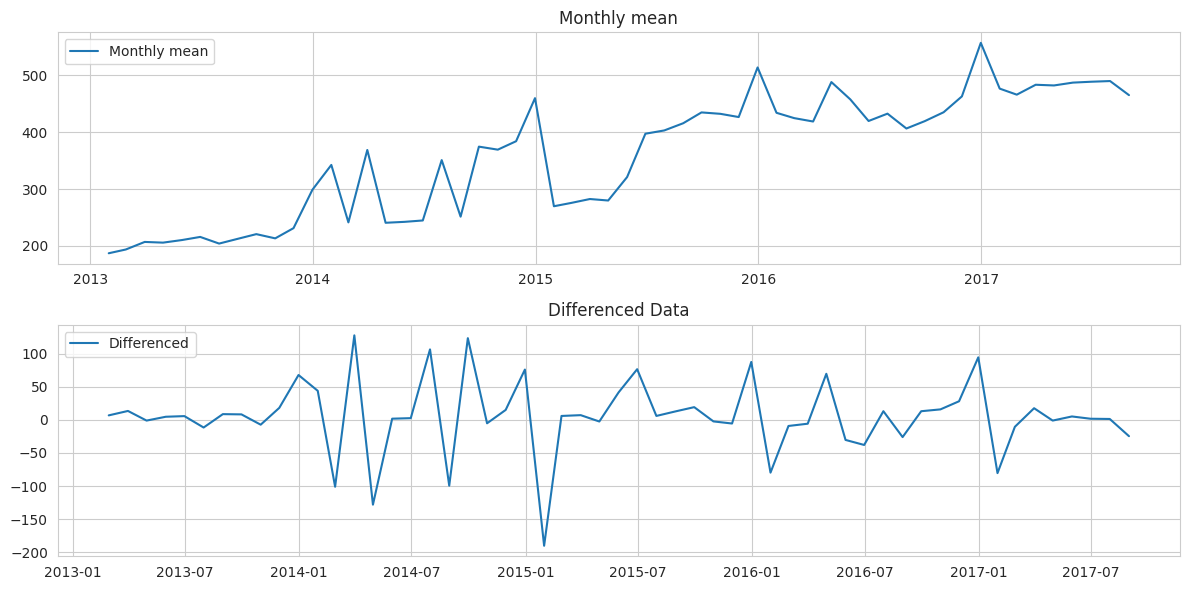

In [216]:

# first-order differencing on the target variable
differenced_data = merged_monthly_mean - merged_monthly_mean.shift(1)

# Plot the original and differenced time series
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(merged_monthly_mean, label='Monthly mean')
plt.legend(loc='upper left')
plt.title('Monthly mean')

plt.subplot(212)
plt.plot(differenced_data, label='Differenced')
plt.legend(loc='upper left')
plt.title('Differenced Data')

plt.tight_layout()
plt.show()

In [217]:
stats, p, lags, critical_values=kpss(merged_monthly_mean, 'ct')

print(f'Test_statistics: {stats}')
print(f'p-value: {p}')
print(f'Critical values: {critical_values}')

if p < 0.05 :
    print('Series is not stationary')
else :
    print('Series is stationary')

Test_statistics: 0.07972350455439596
p-value: 0.1
Critical values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Series is stationary


# Encoding

In [218]:
# using one hot encoder to encode family column

cat = ["family"]

# Initialize the OneHotEncoder
cat_train_encoder = OneHotEncoder()

# Fit and transform the categorical features
encoded_train_features = cat_train_encoder.fit_transform(merged_train[cat])

# Convert the encoded features to a DataFrame
encoded_train_df = pd.DataFrame(encoded_train_features.toarray(), columns=cat_train_encoder.get_feature_names_out(merged_train[cat].columns))

encoded_train_df

,family_AUTOMOTIVE,family_BEAUTY AND FASHION,family_BEVERAGES AND LIQUOR,family_FROZEN FOODS,family_GROCERY,family_HOME AND KITCHEN,family_HOME CARE AND GARDEN,family_PET SUPPLIES,family_SCHOOL AND OFFICE SUPPLIES
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
3054343,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3054344,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3054345,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3054346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [219]:
# encoded categories

cat_train_encoder.categories_

[array(['AUTOMOTIVE', 'BEAUTY AND FASHION', 'BEVERAGES AND LIQUOR',
        'FROZEN FOODS', 'GROCERY', 'HOME AND KITCHEN',
        'HOME CARE AND GARDEN', 'PET SUPPLIES',
        'SCHOOL AND OFFICE SUPPLIES'], dtype=object)]

In [220]:
# to numpy array

encoded_train_features.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [221]:
# Concatenate the encoded columns with the original data

merged_train_encoded = pd.concat([merged_train.reset_index(drop=True), encoded_train_df], axis=1)

In [222]:
merged_train_encoded.head()

,id,date,store_nbr,family,sales,onpromotion,store_cluster,oil_price,events,Year,Month,Day,quarter,week_of_year,day_of_week,is_weekend,family_AUTOMOTIVE,family_BEAUTY AND FASHION,family_BEVERAGES AND LIQUOR,family_FROZEN FOODS,family_GROCERY,family_HOME AND KITCHEN,family_HOME CARE AND GARDEN,family_PET SUPPLIES,family_SCHOOL AND OFFICE SUPPLIES
0,0.0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0,13,93.14,1,2013,1,1,1,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,2013-01-01,1.0,BEAUTY AND FASHION,0.0,0.0,13,93.14,1,2013,1,1,1,1,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,2013-01-01,1.0,BEAUTY AND FASHION,0.0,0.0,13,93.14,1,2013,1,1,1,1,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,2013-01-01,1.0,BEVERAGES AND LIQUOR,0.0,0.0,13,93.14,1,2013,1,1,1,1,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,2013-01-01,1.0,SCHOOL AND OFFICE SUPPLIES,0.0,0.0,13,93.14,1,2013,1,1,1,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [223]:
# drop original cat column

final_train = merged_train_encoded.drop(columns = ["family"])

In [224]:
final_train.tail()

,id,date,store_nbr,sales,onpromotion,store_cluster,oil_price,events,Year,Month,Day,quarter,week_of_year,day_of_week,is_weekend,family_AUTOMOTIVE,family_BEAUTY AND FASHION,family_BEVERAGES AND LIQUOR,family_FROZEN FOODS,family_GROCERY,family_HOME AND KITCHEN,family_HOME CARE AND GARDEN,family_PET SUPPLIES,family_SCHOOL AND OFFICE SUPPLIES
3054343,3000883.0,2017-08-15,9.0,438.133,0.0,6,47.57,1,2017,8,15,3,33,1,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3054344,3000884.0,2017-08-15,9.0,154.553,1.0,6,47.57,1,2017,8,15,3,33,1,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3054345,3000885.0,2017-08-15,9.0,2419.729,148.0,6,47.57,1,2017,8,15,3,33,1,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3054346,3000886.0,2017-08-15,9.0,121.000,8.0,6,47.57,1,2017,8,15,3,33,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3054347,3000887.0,2017-08-15,9.0,16.000,0.0,6,47.57,1,2017,8,15,3,33,1,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# Scaling

In [225]:

final_train.columns

Index(['id', 'date', 'store_nbr', 'sales', 'onpromotion', 'store_cluster',
       'oil_price', 'events', 'Year', 'Month', 'Day', 'quarter',
       'week_of_year', 'day_of_week', 'is_weekend', 'family_AUTOMOTIVE',
       'family_BEAUTY AND FASHION', 'family_BEVERAGES AND LIQUOR',
       'family_FROZEN FOODS', 'family_GROCERY', 'family_HOME AND KITCHEN',
       'family_HOME CARE AND GARDEN', 'family_PET SUPPLIES',
       'family_SCHOOL AND OFFICE SUPPLIES'],
      dtype='object')

In [226]:
# define the columns to be scaled
cols_to_scale = ['store_nbr', 'sales', 'onpromotion', 'store_cluster', 'oil_price',
                  'Year', 'Month', 'Day', 'quarter', 'week_of_year',
                  'day_of_week', 'is_weekend']

# instance of standard scaler
scaler = StandardScaler()

# output the transformed data as a pandas DataFrame instead of NumPy array
scaler.set_output(transform="pandas")

# fit scaler to selected columns
scaler.fit(final_train[cols_to_scale])

StandardScaler()

In [227]:
final_train_2 = final_train.copy()

In [228]:
# Transform the selected columns and replace the original columns with the scaled ones
final_train_2[cols_to_scale] = scaler.transform(final_train[cols_to_scale])

In [229]:
final_train_2.tail()

,id,date,store_nbr,sales,onpromotion,store_cluster,oil_price,events,Year,Month,Day,quarter,week_of_year,day_of_week,is_weekend,family_AUTOMOTIVE,family_BEAUTY AND FASHION,family_BEVERAGES AND LIQUOR,family_FROZEN FOODS,family_GROCERY,family_HOME AND KITCHEN,family_HOME CARE AND GARDEN,family_PET SUPPLIES,family_SCHOOL AND OFFICE SUPPLIES
3054343,3000883.0,2017-08-15,-1.186979,0.071447,-0.213586,-0.533682,-0.786664,1,1.603385,0.526674,-0.074641,0.53514,0.521431,-1.003361,-0.635427,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3054344,3000884.0,2017-08-15,-1.186979,-0.184657,-0.131986,-0.533682,-0.786664,1,1.603385,0.526674,-0.074641,0.53514,0.521431,-1.003361,-0.635427,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3054345,3000885.0,2017-08-15,-1.186979,1.861045,11.863180,-0.533682,-0.786664,1,1.603385,0.526674,-0.074641,0.53514,0.521431,-1.003361,-0.635427,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3054346,3000886.0,2017-08-15,-1.186979,-0.214959,0.439212,-0.533682,-0.786664,1,1.603385,0.526674,-0.074641,0.53514,0.521431,-1.003361,-0.635427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3054347,3000887.0,2017-08-15,-1.186979,-0.309785,-0.213586,-0.533682,-0.786664,1,1.603385,0.526674,-0.074641,0.53514,0.521431,-1.003361,-0.635427,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [230]:

# set date column as index

final_train_2=final_train_2.set_index(['date'])

In [231]:
final_train_2.drop(columns='id', inplace=True)

In [232]:
final_train_2.tail()

,store_nbr,sales,onpromotion,store_cluster,oil_price,events,Year,Month,Day,quarter,week_of_year,day_of_week,is_weekend,family_AUTOMOTIVE,family_BEAUTY AND FASHION,family_BEVERAGES AND LIQUOR,family_FROZEN FOODS,family_GROCERY,family_HOME AND KITCHEN,family_HOME CARE AND GARDEN,family_PET SUPPLIES,family_SCHOOL AND OFFICE SUPPLIES
date,,,,,,,,,,,,,,,,,,,,,,
2017-08-15,-1.186979,0.071447,-0.213586,-0.533682,-0.786664,1,1.603385,0.526674,-0.074641,0.53514,0.521431,-1.003361,-0.635427,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2017-08-15,-1.186979,-0.184657,-0.131986,-0.533682,-0.786664,1,1.603385,0.526674,-0.074641,0.53514,0.521431,-1.003361,-0.635427,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2017-08-15,-1.186979,1.861045,11.863180,-0.533682,-0.786664,1,1.603385,0.526674,-0.074641,0.53514,0.521431,-1.003361,-0.635427,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2017-08-15,-1.186979,-0.214959,0.439212,-0.533682,-0.786664,1,1.603385,0.526674,-0.074641,0.53514,0.521431,-1.003361,-0.635427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2017-08-15,-1.186979,-0.309785,-0.213586,-0.533682,-0.786664,1,1.603385,0.526674,-0.074641,0.53514,0.521431,-1.003361,-0.635427,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [233]:
# save to csv

final_train_2.to_csv('encoded_train_data.csv', index=False)

# Train and Test Data

In [234]:
merged_monthly_mean.shape

(56, 1)

In [235]:
# splitting train and eval set for daily data

train_monthly = merged_monthly_mean[0:40]
eval_monthly = merged_monthly_mean[40:]

# 4. Modelling

## 1. AR model

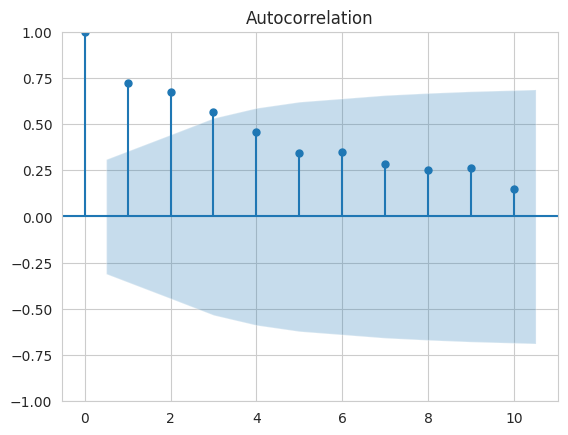

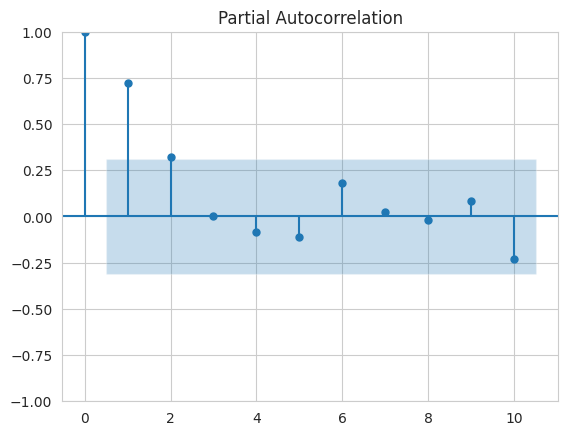

In [236]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf = plot_acf(train_monthly['sales'], lags = 10)
pacf = plot_pacf(train_monthly['sales'], lags =10)

In [237]:
from statsmodels.tsa.ar_model import AutoReg

model_1 = AutoReg(train_monthly, lags = 6).fit()

In [238]:
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  sales   No. Observations:                   40
Model:                     AutoReg(6)   Log Likelihood                -183.219
Method:               Conditional MLE   S.D. of innovations             52.977
Date:                Thu, 26 Sep 2024   AIC                            382.439
Time:                        18:54:24   BIC                            394.649
Sample:                    07-31-2013   HQIC                           386.603
                         - 04-30-2016                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.4436     41.023      0.937      0.349     -41.960     118.847
sales.L1       0.3973      0.163      2.437      0.015       0.078       0.717
sales.L2       0.4395      0.176      2.493      0.013       0.094       0.785
sales.L3       0.0340      0.188      0.180      0.857      -0.335       0.403
sales.L4      -0.2174      0.188     -1.155      0.248      -0.586       0.151
sales.L5      -0.1319      0.187     -0.706      0.480      -0.498       0.234
sales.L6       0.4166      0.173      2.402      0.016       0.077       0.756
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1643           -0.0000j            1.1643           -0.5000
AR.2           -0.6198           -1.0032j            1.1792           -0.3381
AR.3           -0.6198           +1.0032j            1.1792            0.3381
AR.4            1.0252           -0.0000j            1.0252           -0.0000
AR.5            0.8477           -0.8531j            1.2026           -0.1255
AR.6            0.8477           +0.8531j            1.2026            0.1255
-----------------------------------------------------------------------------
"""

In [239]:
AR_pred = model_1.predict (start = len(train_monthly),
                           end = len(train_monthly) + len(eval_monthly) - 1,
                           dynamic = False
                           )

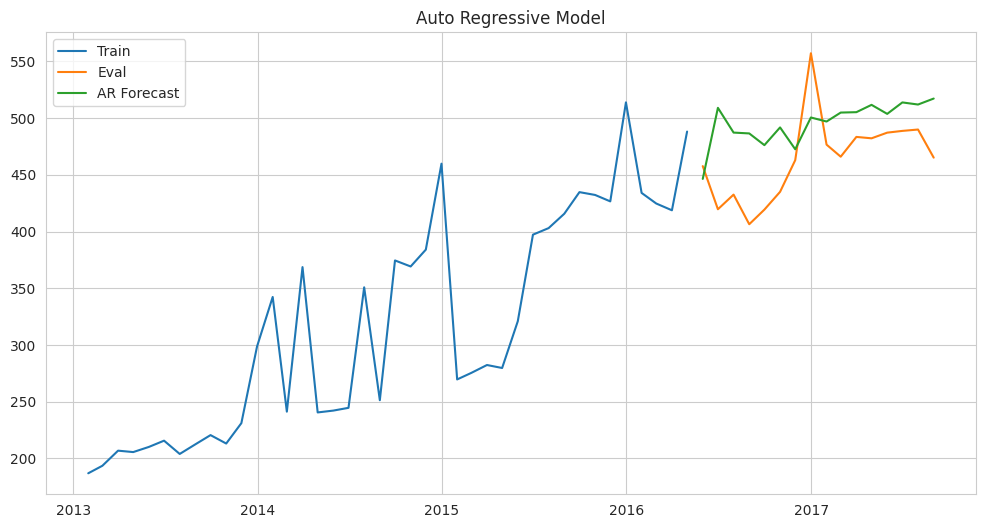

In [240]:
plt.figure(figsize = (12,6))
plt.plot(train_monthly['sales'], label = 'Train')
plt.plot(eval_monthly['sales'], label = 'Eval')
plt.plot (AR_pred, label = 'AR Forecast')
plt.legend(loc='upper left')
plt.title('Auto Regressive Model')
plt.show()

In [241]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

mse = mean_squared_error(eval_monthly, AR_pred)
msle = mean_squared_log_error(eval_monthly, AR_pred)
rmse = np.sqrt(mean_squared_error(eval_monthly, AR_pred )).round(2)
rmsle = np.sqrt(mean_squared_log_error(eval_monthly, AR_pred)).round(2)

results_1 = pd.DataFrame([['AR', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results_1

,Model,MSE,MSLE,RMSE,RMSLE
0,AR,2164.295861,0.009829,46.52,0.1


## 2. ARIMA model

In [242]:
%pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [243]:

# We use pmdarima to determine the best parameter for our ARIMA model.

from pmdarima import auto_arima

stepwise_fit = auto_arima(train_monthly['sales'], trace = True, suppress_warnings = True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=437.525, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=429.622, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=436.112, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=431.158, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=429.012, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=430.786, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=430.801, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=429.340, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=432.769, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.742 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   40
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -212.506
Date:                Thu, 26 Sep 2024   AIC                            429.012
Time:                        18:54:37   BIC                            432.339
Sample:                    01-31-2013   HQIC                           430.206
                         - 04-30-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4569      0.116     -3.924      0.000      -0.685      -0.229
sigma2      3145.8666    722.718      4.353      0.000    1729.365    4562.368
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 2.60
Prob(Q):                              0.61   Prob(JB):                         0.27
Heteroskedasticity (H):               1.53   Skew:                            -0.56
Prob(H) (two-sided):                  0.45   Kurtosis:                         3.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [244]:
from statsmodels.tsa.arima.model import ARIMA

model_2 = ARIMA(train_monthly, order=(1,1,0))
model_2_fit = model_2.fit()
model_2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                   40
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -212.506
Date:                Thu, 26 Sep 2024   AIC                            429.012
Time:                        18:54:37   BIC                            432.339
Sample:                    01-31-2013   HQIC                           430.206
                         - 04-30-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4569      0.116     -3.924      0.000      -0.685      -0.229
sigma2      3145.8666    722.718      4.353      0.000    1729.365    4562.368
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 2.60
Prob(Q):                              0.61   Prob(JB):                         0.27
Heteroskedasticity (H):               1.53   Skew:                            -0.56
Prob(H) (two-sided):                  0.45   Kurtosis:                         3.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [245]:
# Make predictions on the test data
ARIMA_pred = model_2_fit.predict(start=len(train_monthly),
                                 end=len(train_monthly) + len(eval_monthly) - 1,
                                 typ="levels")

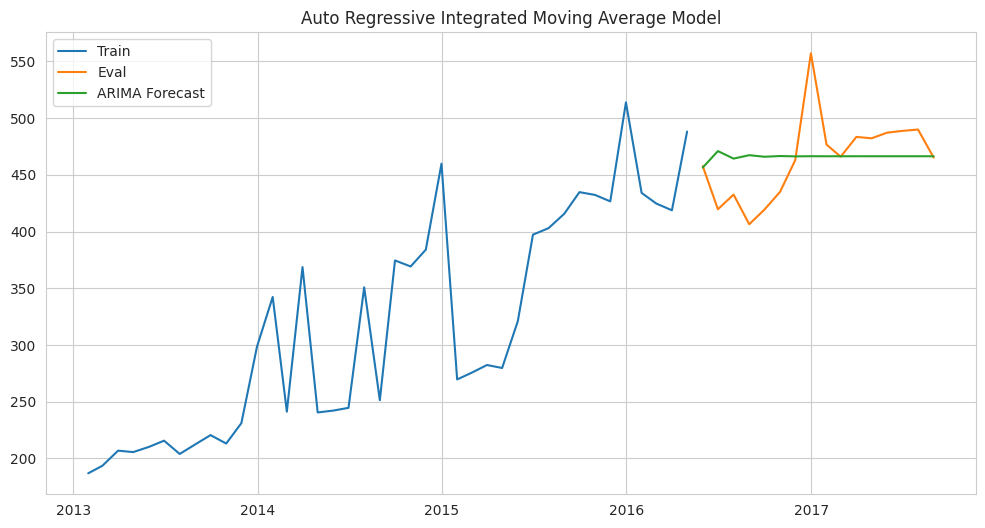

In [246]:
plt.figure(figsize = (12,6))
plt.plot(train_monthly['sales'], label = 'Train')
plt.plot(eval_monthly['sales'], label = 'Eval')
plt.plot (ARIMA_pred, label = 'ARIMA Forecast')
plt.legend(loc='upper left')
plt.title('Auto Regressive Integrated Moving Average Model')
plt.show()

In [247]:

mse = mean_squared_error(eval_monthly, ARIMA_pred)
msle = mean_squared_log_error(eval_monthly, ARIMA_pred)
rmse = np.sqrt(mean_squared_error(eval_monthly, ARIMA_pred )).round(2)
rmsle = np.sqrt(mean_squared_log_error(eval_monthly, ARIMA_pred)).round(2)

model_results = pd.DataFrame([['ARIMA', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results_2 = pd.concat([results_1, model_results], ignore_index=True)
results_2

,Model,MSE,MSLE,RMSE,RMSLE
0,AR,2164.295861,0.009829,46.52,0.10
1,ARIMA,1305.076721,0.005901,36.13,0.08


## 3. SARIMA model

In [248]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_3 = SARIMAX(train_monthly, order=(1,1,0), seasonal_order=(1,0,0,12)) 
model_3_fit = model_3.fit()
model_3_fit.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.29666D+00    |proj g|=  1.87489D-02

At iterate    5    f=  5.29640D+00    |proj g|=  3.14505D-03

At iterate   10    f=  5.29535D+00    |proj g|=  1.39246D-02

At iterate   15    f=  5.29516D+00    |proj g|=  1.07292D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     18      1     0     0   1.073D-07   5.295D+00
  F =   5.2951566765192677     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              sales   No. Observations:                   40
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -211.806
Date:                            Thu, 26 Sep 2024   AIC                            429.613
Time:                                    18:54:38   BIC                            434.603
Sample:                                01-31-2013   HQIC                           431.403
                                     - 04-30-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4776      0.130     -3.682      0.000      -0.732      -0.223
ar.S.L12       0.1908      0.225      0.849      0.396      -0.250       0.631
sigma2      2998.7291    682.025      4.397      0.000    1661.984    4335.474
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 7.07
Prob(Q):                              0.73   Prob(JB):                         0.03
Heteroskedasticity (H):               1.26   Skew:                            -0.76
Prob(H) (two-sided):                  0.68   Kurtosis:                         4.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [249]:
# Make predictions on the test data
SARIMA_pred = model_3_fit.predict(start=len(train_monthly),
                                 end=len(train_monthly) + len(eval_monthly) - 1,
                                 typ="levels")

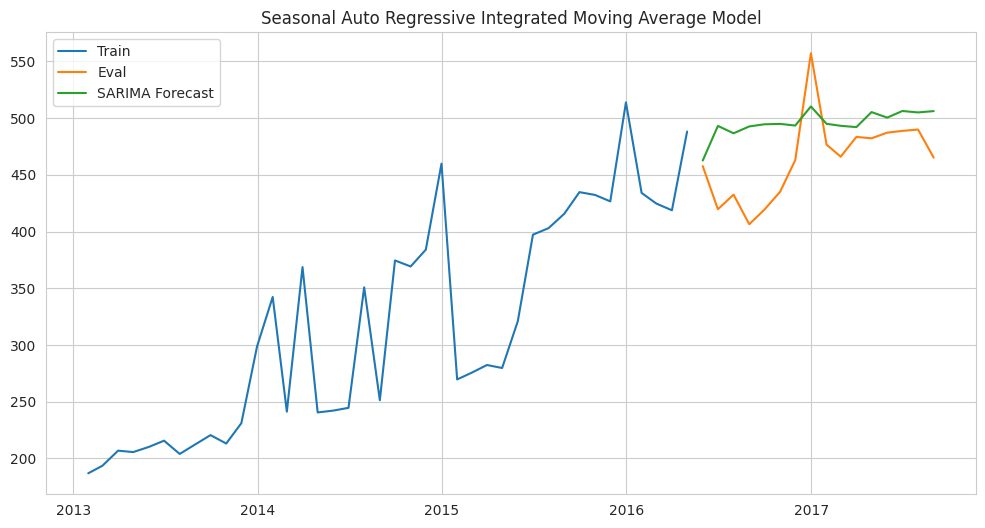

In [250]:
plt.figure(figsize = (12,6))
plt.plot(train_monthly['sales'], label = 'Train')
plt.plot(eval_monthly['sales'], label = 'Eval')
plt.plot (SARIMA_pred, label = 'SARIMA Forecast')
plt.legend(loc='upper left')
plt.title('Seasonal Auto Regressive Integrated Moving Average Model')
plt.show()

In [251]:
mse = mean_squared_error(eval_monthly, SARIMA_pred)
msle = mean_squared_log_error(eval_monthly, SARIMA_pred)
rmse = np.sqrt(mean_squared_error(eval_monthly, SARIMA_pred )).round(2)
rmsle = np.sqrt(mean_squared_log_error(eval_monthly, SARIMA_pred)).round(2)

model_results = pd.DataFrame([['SARIMA', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results_3 = pd.concat([results_2, model_results], ignore_index=True)
results_3

,Model,MSE,MSLE,RMSE,RMSLE
0,AR,2164.295861,0.009829,46.52,0.10
1,ARIMA,1305.076721,0.005901,36.13,0.08
2,SARIMA,2013.385641,0.009321,44.87,0.10


# Traditional ML Models

In [252]:

final_train.shape

(3054348, 24)

In [253]:
final_train.reset_index(inplace=True)
final_train.head()

,index,id,date,store_nbr,sales,onpromotion,store_cluster,oil_price,events,Year,Month,Day,quarter,week_of_year,day_of_week,is_weekend,family_AUTOMOTIVE,family_BEAUTY AND FASHION,family_BEVERAGES AND LIQUOR,family_FROZEN FOODS,family_GROCERY,family_HOME AND KITCHEN,family_HOME CARE AND GARDEN,family_PET SUPPLIES,family_SCHOOL AND OFFICE SUPPLIES
0,0,0.0,2013-01-01,1.0,0.0,0.0,13,93.14,1,2013,1,1,1,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.0,2013-01-01,1.0,0.0,0.0,13,93.14,1,2013,1,1,1,1,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2.0,2013-01-01,1.0,0.0,0.0,13,93.14,1,2013,1,1,1,1,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,3.0,2013-01-01,1.0,0.0,0.0,13,93.14,1,2013,1,1,1,1,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,4.0,2013-01-01,1.0,0.0,0.0,13,93.14,1,2013,1,1,1,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [254]:
final_train.drop(columns='date', inplace= True)

In [255]:
# Split data into parts
x = final_train.drop(['sales'], axis = 1)
y = final_train['sales']

In [256]:
# Split data into Train Test
X_train, X_test, y_train, y_test = x[0:2000000], x[2000000:], y[0:2000000], y[2000000:]

In [257]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2000000, 23), (1054348, 23), (2000000,), (1054348,))

## 4. Linear Regression

In [258]:
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression()
model_lin = lin_model.fit(X_train, y_train)

# Make prediction on X_test
lin_pred = model_lin.predict(X_test)

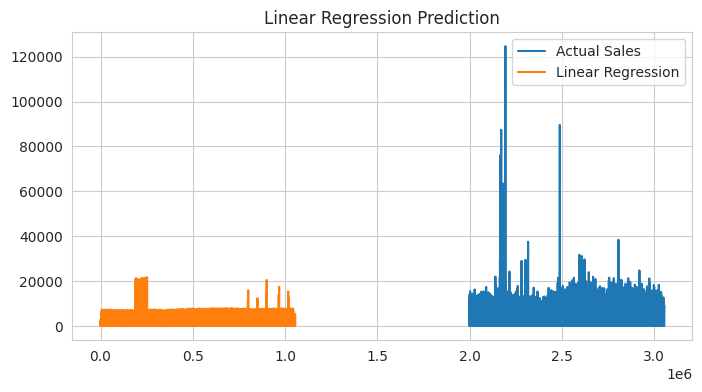

In [259]:

plt.figure(figsize=(8,4))
plt.plot(y_test, label ='Actual Sales')
plt.plot(lin_pred, label='Linear Regression')
plt.legend(loc='best')
plt.title('Linear Regression Prediction')
plt.show()

In [260]:

mse = mean_squared_error(y_test, lin_pred )
rmse = np.sqrt(mean_squared_error(y_test, lin_pred )).round(2)

results = pd.DataFrame([['Linear', mse, rmse]], columns = ['Model', 'MSE', 'RMSE'])
results_4 = pd.concat([results_3, results], ignore_index=True)
results_4

,Model,MSE,MSLE,RMSE,RMSLE
0,AR,2.164296e+03,0.009829,46.52,0.10
1,ARIMA,1.305077e+03,0.005901,36.13,0.08
2,SARIMA,2.013386e+03,0.009321,44.87,0.10
3,Linear,1.143943e+06,NaN,1069.55,NaN


## Decision tree

In [261]:
from sklearn.tree import DecisionTreeRegressor

In [262]:
decision_tree = DecisionTreeRegressor(random_state=42)
decision_tree_model = decision_tree.fit(X_train, y_train)

In [263]:
# Make prediction on test

predict_tree = decision_tree.predict(X_test)

<BarContainer object of 23 artists>

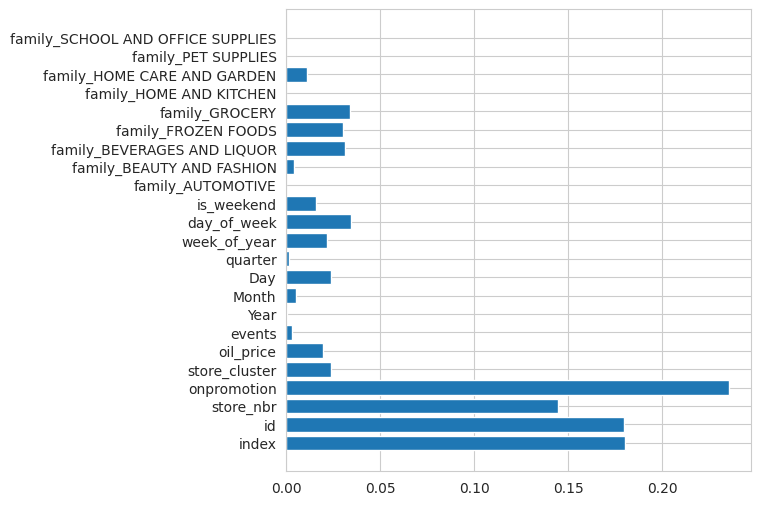

In [264]:

#feature importance

plt.figure(figsize = (6,6))
plt.barh(X_train.columns, decision_tree_model.feature_importances_)

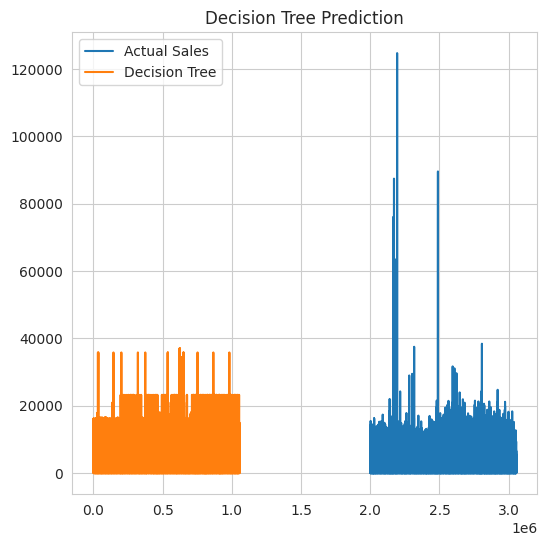

In [265]:

# predicted and actual data

plt.figure(figsize=(6,6))
plt.plot(y_test, label = "Actual Sales")
plt.plot(predict_tree, label = "Decision Tree")
plt.legend(loc = "best")
plt.title("Decision Tree Prediction")
plt.show()

In [266]:
# Evaluation metrics

mse = mean_squared_error(y_test, predict_tree)
msle = mean_squared_log_error(y_test, predict_tree)
rmse = np.sqrt(mean_squared_error(y_test, predict_tree )).round(2)
rmsle = np.sqrt(mean_squared_log_error(y_test, predict_tree)).round(2)

results = pd.DataFrame([['Decision Tree', mse,msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results_5 = pd.concat([results_4, results], ignore_index=True)
results_5

,Model,MSE,MSLE,RMSE,RMSLE
0,AR,2.164296e+03,0.009829,46.52,0.10
1,ARIMA,1.305077e+03,0.005901,36.13,0.08
2,SARIMA,2.013386e+03,0.009321,44.87,0.10
3,Linear,1.143943e+06,NaN,1069.55,NaN
4,Decision Tree,3.481521e+06,5.338760,1865.88,2.31


## Xg Boost

In [267]:
from sklearn.ensemble import GradientBoostingRegressor

In [268]:
xgc = GradientBoostingRegressor(random_state=42) 
xg_boost = xgc.fit(X_train, y_train)

In [269]:
# Predicting the Test set results
xg_boost_pred  = xgc.predict(X_test)

<BarContainer object of 23 artists>

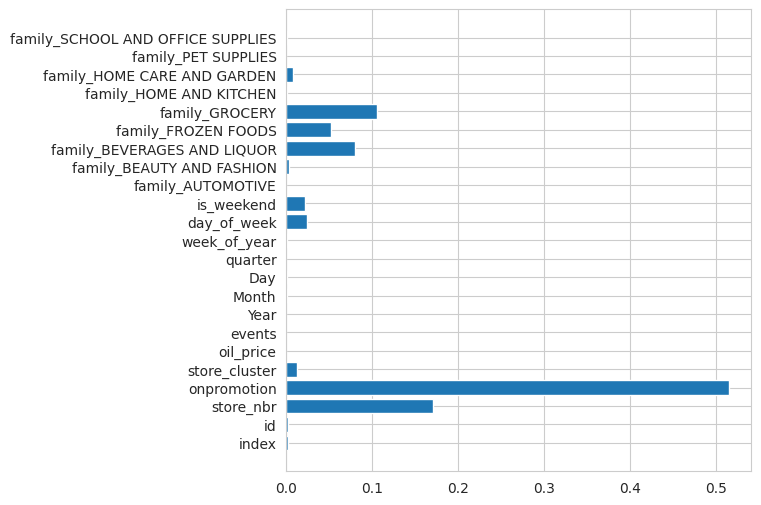

In [270]:

#feature importance

plt.figure(figsize = (6,6))
plt.barh(X_train.columns, xg_boost.feature_importances_)

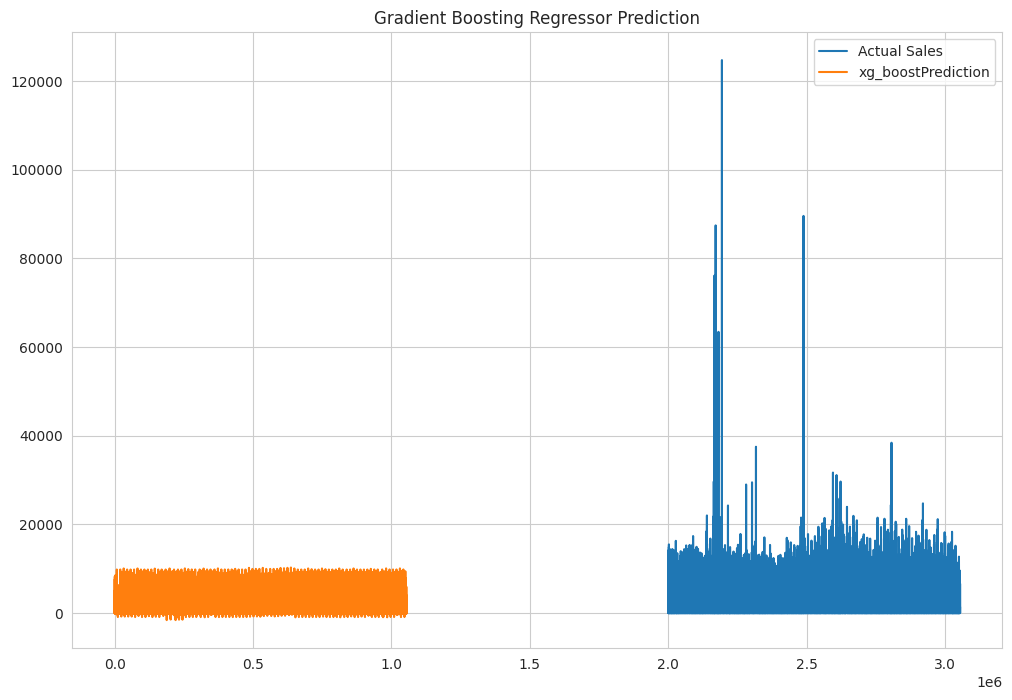

In [271]:
# predicted and actual data

plt.figure(figsize=(12,8))
plt.plot(y_test, label = "Actual Sales")
plt.plot(xg_boost_pred, label = "xg_boostPrediction")
plt.legend(loc = "best")
plt.title("Gradient Boosting Regressor Prediction")
plt.show()

In [272]:
# Evaluation Metrics

mse = mean_squared_error(y_test, xg_boost_pred)
rmse = np.sqrt(mean_squared_error(y_test, xg_boost_pred)).round(2)

results = pd.DataFrame([['XG Boost', mse, rmse]], columns = ['Model', 'MSE', 'RMSE'])
results_6 = pd.concat([results_5, results], ignore_index=True)
results_6

,Model,MSE,MSLE,RMSE,RMSLE
0,AR,2.164296e+03,0.009829,46.52,0.10
1,ARIMA,1.305077e+03,0.005901,36.13,0.08
2,SARIMA,2.013386e+03,0.009321,44.87,0.10
3,Linear,1.143943e+06,NaN,1069.55,NaN
4,Decision Tree,3.481521e+06,5.338760,1865.88,2.31
5,XG Boost,1.356880e+06,NaN,1164.85,NaN


In [273]:
merged_monthly_mean

,sales
date,
2013-01-31,186.952405
2013-02-28,193.581846
2013-03-31,206.880581
2013-04-30,205.639071
2013-05-31,210.184563
2013-06-30,215.691343
2013-07-31,203.983455
2013-08-31,212.479434
2013-09-30,220.593588


In [274]:
backtests = {
    1: ('2017-05-31', '2017-06-30'),
    2: ('2017-06-30', '2017-07-31'),
    3: ('2017-07-31', '2017-08-31')
}

# Backtests with ARIMA Model
scores = {}

for period in backtests.values():

    # Convert date strings to datetime objects
    start_date = pd.to_datetime(period[0])
    end_date = pd.to_datetime(period[1])

    # Filter the DataFrame based on datetime comparisons
    _train = merged_monthly_mean.reset_index()[merged_monthly_mean.reset_index()['date'] < start_date]
    _test = merged_monthly_mean.reset_index()[(merged_monthly_mean.reset_index()['date'] >= start_date) & (merged_monthly_mean.reset_index()['date'] <= end_date)]
    
    Xtrain = _train.sales.values
    Xtest = _test.sales.values
    
    try:
        model = ARIMA(Xtrain, order=(1, 1, 0)).fit()

        # Initialize an empty array to store predictions
        ypred = []

        # Iterate through each data point in the test set and predict one step ahead
        for i in range(len(Xtest)):
            # Predict one step ahead by retraining the model
            ARIMA_model = ARIMA(Xtrain, order=(1, 1, 0)).fit()
            prediction = ARIMA_model.forecast(steps=1)[0]
            
            # Append the prediction to the result
            ypred.append(prediction)

            # Update the training data with the actual value
            Xtrain = np.append(Xtrain, Xtest[i])

        # Calculate RMSLE for the entire period
        rmsle = np.sqrt(mean_squared_log_error(Xtest, ypred))
        scores[str(period)] = rmsle
    except Exception as e:
        print(f"Error in period {period}: {str(e)}")

print(scores)

{"('2017-05-31', '2017-06-30')": 0.008402829693955229, "('2017-06-30', '2017-07-31')": 0.005966513027515483, "('2017-07-31', '2017-08-31')": 0.03596285186453932}


In [275]:
merged_monthly_mean.index = pd.to_datetime(merged_monthly_mean.index)

merged_monthly_mean.index.max()

Timestamp('2017-08-31 00:00:00')

In [276]:
# Define the last observed date
last_observed_date = pd.to_datetime("2017-08-31")

# Define the end date of the year
end_of_year = pd.to_datetime("2017-12-31")

# Create a list of future dates for prediction (monthly frequency)
future_dates = pd.date_range(start=last_observed_date + pd.DateOffset(months=1), end=end_of_year, freq='M')

# Make predictions for future dates
# Replace 'steps' with the number of future predictions you want
predictions = ARIMA_model.forecast(steps=len(future_dates))

# Create a DataFrame to store predictions and dates
future_predictions = pd.DataFrame({'date': future_dates, 'predicted_sales': predictions})

# Print or save the predictions for analysis
print(future_predictions)

        date  predicted_sales
0 2017-09-30       489.396112
1 2017-10-31       489.615601
2 2017-11-30       489.521832
3 2017-12-31       489.561891


In [277]:
future_predictions.to_csv('future_predictions.csv', index=False)